In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

import _pickle as cPickle
import matplotlib as mpl

In [2]:
cat = np.genfromtxt('../forElena16Nov/SAGITTARIUS-II_cat16Nov.dat',names=True)

In [3]:
xgood = cat['x_f606w']
ygood = cat['y_f606w']
m606 = cat['magr_f606w']
dm606 = cat['err_f606w']
m814 = cat['magr_f814w']
dm814 = cat['err_f814w']

In [4]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [5]:
def returnPDF(rich,x0,y0,gal_ext_pix,gal_ell,gal_pa):
    
    costh = np.cos(-1 * np.deg2rad(gal_pa))
    sinth = np.sin(-1 * np.deg2rad(gal_pa))

    dx = xbin - x0
    dy = ybin - y0

    r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
    r2 = (dx * sinth + dy * costh)

    radius = np.sqrt(r1**2 + r2**2)
    
    r_h = gal_ext_pix
    norm = r_h**2 / (np.pi * (1-gal_ell))
    # half light radius squared / (pi * 1-ell)
    pdf = norm/((radius**2 + r_h**2)**2)
    
    arr = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
    r_annuli = (arr + 0.05) * r_h

    # .05r_h, .15r_h
    area_annuli = np.pi * ( (r_annuli + (0.05*r_h))**2 - (r_annuli - (0.05*r_h))**2) * (1-gal_ell)
    
#     pix_per_arcsec=20
#     area_arcmin = area_annuli/(pix_per_arcsec*60)**2
    
    aa = area_annuli # trying. to do everything in pixel space right now

    return pdf, radius, aa


In [6]:
samples_h = cPickle.load( open( "sag2mcmcPL1902-2.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich_h,[rich_min,rich_max] = median_interval(samples_h[:,0])
x_h,[xmin,xmax] = median_interval(samples_h[:,1])
y_h,[ymin,ymax] = median_interval(samples_h[:,2])
sag2_ext_fit_h,[sag2_ext_min,sag2_ext_max] = median_interval(samples_h[:,3])
sag2_ell_fit_h,[sag2_ell_min,sag2_ell_max] = median_interval(samples_h[:,4])
sag2_pa_fit_h,[sag2_pa_min,sag2_pa_max] = median_interval(samples_h[:,5])

res = [rich_h,rich_max-rich_h,rich_h-rich_min,x_h,xmax-x_h,x_h-xmin,y_h,ymax-y_h,y_h-ymin,
           sag2_ext_fit_h,sag2_ext_max-sag2_ext_fit_h,sag2_ext_fit_h-sag2_ext_min,
           sag2_ell_fit_h,sag2_ell_max-sag2_ell_fit_h,sag2_ell_fit_h-sag2_ell_min,
           sag2_pa_fit_h,sag2_pa_max-sag2_pa_fit_h,sag2_pa_fit_h-sag2_pa_min]

print(res)

[7797.203862521483, 175.1170013876881, 169.9691550171883, 2329.9465406833224, 23.077491706560068, 23.190543779932796, 2181.2670905972664, 27.52270906633248, 27.484441464997417, 2216.950480728354, 62.63551251306626, 60.09283508331464, 0.14159011019323087, 0.02659166698660012, 0.027261593328883893, -16.455886266280395, 5.2845732523603814, 5.6478025933461815]


In [7]:
rich_j = 6071
x_j = 2527
y_j = 2235
sag2_ext_fit_j = 2677
sag2_ell_fit_j = 0.14
sag2_pa_fit_j = -8

In [8]:
# richness = 6071 +720/-960  [seems large, given the total number of stars in the catalog]
# x_center = 2527 + 47/-45
# y_center = 2235 +53/-51
# rhalf = 2677 +195/-202 -> 2.23’
# ellip = 0.14 +0.05/-0.06   [maybe marginally consistent with published limits]
# PA = -8 +11/-12

In [9]:
xbin0 = np.ones((179,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,179))  
xbin1[0] = np.arange(0,179,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [10]:
pdf_h, rad_h, aa_h = returnPDF(rich_h,x_h,y_h,sag2_ext_fit_h,
                                        sag2_ell_fit_h,sag2_pa_fit_h)

In [11]:
pdf_j, rad_j, aa_j = returnPDF(rich_j,x_j,y_j,sag2_ext_fit_j,
                                        sag2_ell_fit_j,sag2_pa_fit_j)

In [12]:
model_counts_h = rich_h*pdf_h*pixarea  # a 179x179 array
model_counts_j = rich_j*pdf_j*pixarea  # a 179x179 array

In [13]:
# Observed surface density map
binned_surface_density_30 = np.zeros((179,179))
for ii in range(179):
    for jj in range(179):
        idx = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idx)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [14]:
# Define annuli
radiusH=rad_h.flatten()
r_h_h = sag2_ext_fit_h
r1_h = np.where(radiusH < (0.1 * r_h_h))[0]
r2_h = np.where((radiusH < (0.2 * r_h_h)) & (radiusH >= (0.1 * r_h_h)))[0]
r3_h = np.where((radiusH < (0.3 * r_h_h)) & (radiusH >= (0.2 * r_h_h)))[0]
r4_h = np.where((radiusH < (0.4 * r_h_h)) & (radiusH >= (0.3 * r_h_h)))[0]
r5_h = np.where((radiusH < (0.5 * r_h_h)) & (radiusH >= (0.4 * r_h_h)))[0]
r6_h = np.where((radiusH < (0.6 * r_h_h)) & (radiusH >= (0.5 * r_h_h)))[0]
r7_h = np.where((radiusH < (0.7 * r_h_h)) & (radiusH >= (0.6 * r_h_h)))[0]
r8_h = np.where((radiusH < (0.8 * r_h_h)) & (radiusH >= (0.7 * r_h_h)))[0]
r9_h = np.where((radiusH < (0.9 * r_h_h)) & (radiusH >= (0.8 * r_h_h)))[0]
r10_h = np.where((radiusH < r_h_h) & (radiusH >= (0.9 * r_h_h)))[0]

In [15]:
# Define annuli
radiusJ=rad_j.flatten()
r_h_j = sag2_ext_fit_j
r1_j = np.where(radiusJ < (0.1 * r_h_j))[0]
r2_j = np.where((radiusJ < (0.2 * r_h_j)) & (radiusJ >= (0.1 * r_h_j)))[0]
r3_j = np.where((radiusJ < (0.3 * r_h_j)) & (radiusJ >= (0.2 * r_h_j)))[0]
r4_j = np.where((radiusJ < (0.4 * r_h_j)) & (radiusJ >= (0.3 * r_h_j)))[0]
r5_j = np.where((radiusJ < (0.5 * r_h_j)) & (radiusJ >= (0.4 * r_h_j)))[0]
r6_j = np.where((radiusJ < (0.6 * r_h_j)) & (radiusJ >= (0.5 * r_h_j)))[0]
r7_j = np.where((radiusJ < (0.7 * r_h_j)) & (radiusJ >= (0.6 * r_h_j)))[0]
r8_j = np.where((radiusJ < (0.8 * r_h_j)) & (radiusJ >= (0.7 * r_h_j)))[0]
r9_j = np.where((radiusJ < (0.9 * r_h_j)) & (radiusJ >= (0.8 * r_h_j)))[0]
r10_j = np.where((radiusJ < r_h_j) & (radiusJ >= (0.9 * r_h_j)))[0]

In [16]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_sag2_h_f = model_counts_h.flatten()
model_counts_sag2_j_f = model_counts_j.flatten()

In [17]:
data_1d_h = [binned_surface_density_30f[r1_h].sum()/aa_h[0],
           binned_surface_density_30f[r2_h].sum()/aa_h[1],
           binned_surface_density_30f[r3_h].sum()/aa_h[2],
           binned_surface_density_30f[r4_h].sum()/aa_h[3],
           binned_surface_density_30f[r5_h].sum()/aa_h[4],
           binned_surface_density_30f[r6_h].sum()/aa_h[5],
           binned_surface_density_30f[r7_h].sum()/aa_h[6],
           binned_surface_density_30f[r8_h].sum()/aa_h[7],
           binned_surface_density_30f[r9_h].sum()/aa_h[8],
           binned_surface_density_30f[r10_h].sum()/aa_h[9]]

data_1d_j = [binned_surface_density_30f[r1_j].sum()/aa_j[0],
           binned_surface_density_30f[r2_j].sum()/aa_j[1],
           binned_surface_density_30f[r3_j].sum()/aa_j[2],
           binned_surface_density_30f[r4_j].sum()/aa_j[3],
           binned_surface_density_30f[r5_j].sum()/aa_j[4],
           binned_surface_density_30f[r6_j].sum()/aa_j[5],
           binned_surface_density_30f[r7_j].sum()/aa_j[6],
           binned_surface_density_30f[r8_j].sum()/aa_j[7],
           binned_surface_density_30f[r9_j].sum()/aa_j[8],
           binned_surface_density_30f[r10_j].sum()/aa_j[9]]

model_1d_h = [model_counts_sag2_h_f[r1_h].sum()/aa_h[0],
            model_counts_sag2_h_f[r2_h].sum()/aa_h[1],
            model_counts_sag2_h_f[r3_h].sum()/aa_h[2],
            model_counts_sag2_h_f[r4_h].sum()/aa_h[3],
            model_counts_sag2_h_f[r5_h].sum()/aa_h[4],
            model_counts_sag2_h_f[r6_h].sum()/aa_h[5],
            model_counts_sag2_h_f[r7_h].sum()/aa_h[6],
            model_counts_sag2_h_f[r8_h].sum()/aa_h[7],
            model_counts_sag2_h_f[r9_h].sum()/aa_h[8],
            model_counts_sag2_h_f[r10_h].sum()/aa_h[9]]

model_1d_j = [model_counts_sag2_j_f[r1_j].sum()/aa_j[0],
            model_counts_sag2_j_f[r2_j].sum()/aa_j[1],
            model_counts_sag2_j_f[r3_j].sum()/aa_j[2],
            model_counts_sag2_j_f[r4_j].sum()/aa_j[3],
            model_counts_sag2_j_f[r5_j].sum()/aa_j[4],
            model_counts_sag2_j_f[r6_j].sum()/aa_j[5],
            model_counts_sag2_j_f[r7_j].sum()/aa_j[6],
            model_counts_sag2_j_f[r8_j].sum()/aa_j[7],
            model_counts_sag2_j_f[r9_j].sum()/aa_j[8],
            model_counts_sag2_j_f[r10_j].sum()/aa_j[9]]

In [18]:
dist_h = np.array([r_h_h*0.1,r_h_h*0.2,r_h_h*0.3,r_h_h*0.4,r_h_h*0.5,r_h_h*0.6,r_h_h*0.7,r_h_h*0.8,r_h_h*0.9,r_h_h])
dist_j = np.array([r_h_j*0.1,r_h_j*0.2,r_h_j*0.3,r_h_j*0.4,r_h_j*0.5,r_h_j*0.6,r_h_j*0.7,r_h_j*0.8,r_h_j*0.9,r_h_j])

In [20]:
ynew = rich_j/(np.pi*r_h_j**2*(1-sag2_ell_fit_j)) * \
        (1+(dist_j**2/r_h_j**2))**(-2)

In [22]:
ynew_h = rich_h/(np.pi*r_h_h**2*(1-sag2_ell_fit_h)) * \
        (1+(dist_h**2/r_h_h**2))**(-2)

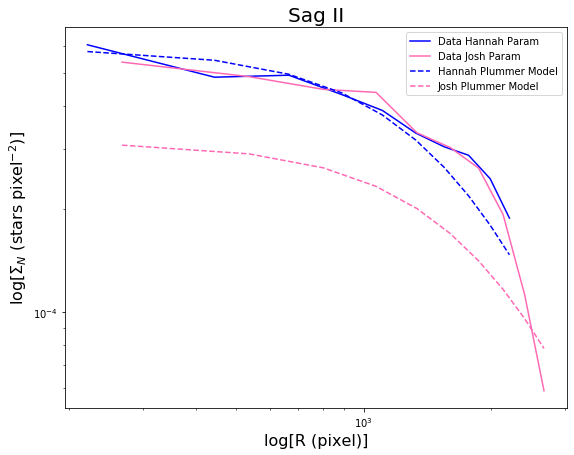

In [24]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_h,data_1d_h,label='Data Hannah Param',color='blue')
ax.plot(dist_j,data_1d_j,label='Data Josh Param',color='hotpink')
ax.plot(dist_h,ynew_h,label='Hannah Plummer Model',color='blue',ls='--')

# ax.plot(dist_h,model_1d_h,label='Model Hannah Param',color='blue',linestyle='--')
# ax.plot(dist_j,model_1d_j,label='Model Josh Param',color='hotpink',linestyle='--')
ax.plot(dist_j,ynew,label='Josh Plummer Model',color='hotpink',ls='--')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars pixel$^{-2}$)]',fontsize=16)
ax.set_xlabel(r'log[R (pixel)]',fontsize=16)
ax.set_title('Sag II',fontsize=20)

# ax.set_xticks([1, 2])
# ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# ax.set_yticks([1e+2, 1e+3])
# ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


ax.legend()
# plt.savefig('figures/sgr2_2302hj.png')
plt.show()